In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
import matplotlib.pyplot as plt
from time import time

In [2]:
mesh = dl.UnitSquareMesh(35, 37)
V = dl.FunctionSpace(mesh, 'CG', 1)
u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

A_fenics = dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test)) * dl.dx + 1e-4 * u_trial*v_test*dl.dx)

def csr_fenics2scipy(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

A = csr_fenics2scipy(A_fenics)

In [3]:
def randomized_range_finder(apply_A, shape_A, 
                            max_rank=5, oversampling_parameter=20, 
                            step=1, tol=1e-6, verbose=False):
    p = oversampling_parameter

    def get_random_matvec():
        return apply_A(np.random.randn(shape_A[1]))
    
    yy = []
    for _ in range(p):
        yy.append(get_random_matvec())

    for r_right in range(step, max_rank + step, step):
        yy = yy + [get_random_matvec() for _ in range(step)]

        Y = np.array(yy).T
        Q0, _, _ = np.linalg.svd(Y, full_matrices=False)
        Q = Q0[:, :r_right]

        norm_estimate = np.linalg.norm(Y)/np.sqrt(len(yy))
        error_estimate = np.max(np.linalg.norm(Y - np.dot(Q, np.dot(Q.T, Y)), axis=0))/norm_estimate
        if verbose:
            print('r_right=', r_right, 'error_estimate=', error_estimate)
        if error_estimate < tol:
            break

    return Q


def randomized_svd(apply_A, apply_At, shape_A, 
                   max_rank=5, oversampling_parameter=20, 
                   step=1, tol=1e-6, verbose=False):
    
    Q = randomized_range_finder(apply_A, shape_A, 
                   max_rank=max_rank, oversampling_parameter=oversampling_parameter, 
                   step=step, tol=tol, verbose=verbose)
    
    X = np.zeros((Q.shape[1], shape_A[1]))
    for k in range(Q.shape[1]):
        X[k,:] = apply_At(Q[:,k])
        
    U0, ss, Vt = np.linalg.svd(X, 0)
    U = np.dot(Q, U0)
    return U, ss, Vt

In [4]:
def block_low_rank_approximation(A, rows, cols, rank=5, verbose=False):
    Arc = A[rows,:][:,cols]
#     A[rows, cols] # <-- Doesn't work
    apply_Arc = lambda x: Arc * x
    apply_Arc_t = lambda x: Arc.T * x
    U, ss, Vt = randomized_svd(apply_Arc, apply_Arc_t, Arc.shape, max_rank=rank, verbose=verbose)
    return U, ss, Vt
#     return spla.svds(Arc, v0=np.random.randn(np.min(Arc.shape)), k=rank)

rr = np.random.randint(0, V.dim(), 100)
cc = np.random.randint(0, V.dim(), 109)

U, ss, Vt = block_low_rank_approximation(A, rr, cc, rank=20, verbose=True)

Arc_dense = A[rr,:][:,cc].toarray()
U_true, ss_true, Vt_true = spla.svds(Arc_dense,k=20)

A_trunc = np.dot(U, np.dot(np.diag(ss), Vt))
A_trunc_true = np.dot(U_true, np.dot(np.diag(ss_true), Vt_true))

err_svd = np.linalg.norm(Arc_dense - A_trunc_true) / np.linalg.norm(Arc_dense)
print('err_svd=', err_svd)

err_rsvd = np.linalg.norm(Arc_dense - A_trunc) / np.linalg.norm(Arc_dense)
print('err_rsvd=', err_rsvd)

r_right= 1 error_estimate= 1.4032120306588378
r_right= 2 error_estimate= 1.0952075795887142
r_right= 3 error_estimate= 0.8640113109015709
r_right= 4 error_estimate= 0.7164070463676503
r_right= 5 error_estimate= 0.7110428380966198
r_right= 6 error_estimate= 0.5734630515145824
r_right= 7 error_estimate= 0.5263472886125697
r_right= 8 error_estimate= 0.5223198837439622
r_right= 9 error_estimate= 0.5037403895440937
r_right= 10 error_estimate= 0.43501933921442143
r_right= 11 error_estimate= 0.40444921047400495
r_right= 12 error_estimate= 0.38128781576309395
r_right= 13 error_estimate= 0.3293397844937198
r_right= 14 error_estimate= 0.2931899686472696
r_right= 15 error_estimate= 0.26623150113724586
r_right= 16 error_estimate= 0.24669800666279293
r_right= 17 error_estimate= 0.24391778197139305
r_right= 18 error_estimate= 0.23546355094679253
r_right= 19 error_estimate= 0.21730226773423916
r_right= 20 error_estimate= 0.2135679288531951
err_svd= 0.2577784547941651
err_rsvd= 0.32667002960308433


In [5]:
class Cluster:
    def __init__(me, start, stop):
        me.start = start
        me.stop = stop
        me.children = []

        me.slice = slice(start, stop)
        me.size = me.stop - me.start

    @property
    def is_leaf(me):
        return len(me.children) == 0

    def __hash__(me):
        return hash((me.start, me.stop))

    def __eq__(me, other):
        return (me.start, me.stop) == (other.start, other.stop)


class ClusterTree:
    def __init__(me, coords_X, min_cluster_size=25, interactive_display=False):
        me.coords_X = coords_X
        me.size, me.spatial_dimension = coords_X.shape
        me.root = Cluster(0, me.size)
        me.perm_e2i = np.arange(me.root.start, me.root.stop)

        clusters_to_be_subdivided = [me.root]
        while clusters_to_be_subdivided:
            c = clusters_to_be_subdivided.pop()
            if c.size > min_cluster_size:
                me.subdivide_cluster(c)
                for c_child in c.children:
                    clusters_to_be_subdivided.append(c_child)

            if interactive_display:
                me.plot_cluster(c)
                plt.draw()
                plt.waitforbuttonpress()
                plt.clf()

        me.perm_i2e = np.argsort(me.perm_e2i)

    def get_cluster_coords(me, c):
        return me.coords_X[me.perm_e2i[c.start: c.stop]].reshape((-1, me.spatial_dimension))

    def get_cluster_bounding_box(me, c):
        Xc = me.get_cluster_coords(c)
        min_pt = np.min(Xc, axis=0).reshape(-1)
        max_pt = np.max(Xc, axis=0).reshape(-1)
        return min_pt, max_pt

    def choose_cluster_splitting_direction(me, c):
        min_pt, max_pt = me.get_cluster_bounding_box(c)
        return np.argmax(max_pt - min_pt) # subdivide in largest direction

    def subdivide_cluster(me, c):
        Xc = me.get_cluster_coords(c)
        k = me.choose_cluster_splitting_direction(c)
        sort_inds = np.argsort(Xc[:,k].reshape(-1))

        left_sort_inds = sort_inds[: int(c.size / 2)]
        right_sort_inds = sort_inds[int(c.size / 2):]

        left_start = c.start
        left_stop = c.start + len(left_sort_inds)
        right_start = left_stop
        right_stop = c.stop

        left_child_cluster = Cluster(left_start, left_stop)
        right_child_cluster = Cluster(right_start, right_stop)

        c.children = [left_child_cluster, right_child_cluster]

        new_left_perm = me.perm_e2i[c.start : c.stop][left_sort_inds].copy()
        new_right_perm = me.perm_e2i[c.start : c.stop][right_sort_inds].copy()

        me.perm_e2i[left_start : left_stop] = new_left_perm
        me.perm_e2i[right_start : right_stop] = new_right_perm

    def plot_cluster(me, c):
        Xc = me.get_cluster_coords(c)
        plt.subplot(1,2,1)
        plt.plot(me.coords_X[:, 0], me.coords_X[:,1], '.k')
        plt.plot(Xc[:, 0], Xc[:, 1], '.r')
        plt.title('start= ' + str(c.start) + ', stop= ' + str(c.stop))
        if not c.is_leaf:
            plt.subplot(1, 2, 2)
            plt.plot(me.coords_X[:, 0], me.coords_X[:, 1], '.k')
            for c_child in c.children:
                Xc_child = me.get_cluster_coords(c_child)
                plt.plot(Xc_child[:, 0], Xc_child[:, 1], '.')
                plt.title('child clusters')

In [6]:
dof_coords = V.tabulate_dof_coordinates()
ct = ClusterTree(dof_coords)

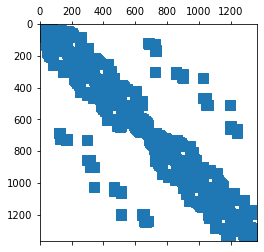

In [7]:
A_perm = A[ct.perm_e2i, :][:, ct.perm_e2i]
plt.spy(A_perm)

In [8]:
class BlockCluster:
    def __init__(me, row_cluster, col_cluster):
        me.row_cluster = row_cluster
        me.col_cluster = col_cluster

        me.slices = (me.row_cluster.slice, me.col_cluster.slice)

        me.children = []

    @property
    def shape(me):
        return (me.row_cluster.size, me.col_cluster.size)

    @property
    def size(me):
        return np.prod(me.shape)

    @property
    def is_leaf(me):
        return len(me.children) == 0
    
    @property
    def is_dense(me):
        return (me.is_leaf and (me.row_cluster == me.col_cluster))
    
    @property
    def is_low_rank(me):
        return me.is_leaf and (not me.is_dense)

    def __hash__(me):
        return hash((me.row_cluster, me.col_cluster))

    def __eq__(me, other):
        return (me.row_cluster, me.col_cluster) == (other.row_cluster, other.col_cluster)
    
    
def build_block_cluster_tree(row_cluster_tree, col_cluster_tree):
    root = BlockCluster(row_cluster_tree.root, col_cluster_tree.root)
    working_blocks = [root]
    while working_blocks:
        B = working_blocks.pop()
        for r in B.row_cluster.children:
            for c in B.col_cluster.children:
                B_child = BlockCluster(r, c)
                B.children.append(B_child)
                if r == c:
                    working_blocks.append(B_child)
    return root

In [9]:
bct_root = build_block_cluster_tree(ct, ct)

In [10]:
bct_root.children[0].col_cluster.stop


684

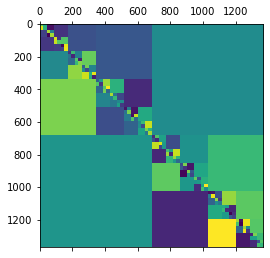

In [11]:
M = np.zeros(bct_root.shape)
working_blocks = [bct_root]
while working_blocks:
    B = working_blocks.pop()
    M[B.row_cluster.slice, B.col_cluster.slice] = np.random.rand()
    for C in B.children:
        working_blocks.append(C)
        
plt.matshow(M)

In [12]:
UU = dict()
SS = dict()
VVt = dict()
DD = dict()

working_blocks = [bct_root]
while working_blocks:
    B = working_blocks.pop()
    rr = B.row_cluster.slice
    cc = B.col_cluster.slice
    if B.is_low_rank:
        U, ss, Vt = block_low_rank_approximation(A_perm, rr, cc, rank=5)
        S = np.diag(ss)
        UU[B] = U
        SS[B] = S
        VVt[B] = Vt
    elif B.is_dense:
        DD[B] = A_perm[rr, cc].toarray()
    else:
        for C in B.children:
            working_blocks.append(C)

In [13]:
A2_perm = np.zeros(A.shape)

working_blocks = [bct_root]
while working_blocks:
    B = working_blocks.pop()
    rr = B.row_cluster.slice
    cc = B.col_cluster.slice
    if B.is_low_rank:
        A2_perm[rr,cc] = np.dot(UU[B], np.dot(SS[B], VVt[B]))
    elif B.is_dense:
        A2_perm[rr,cc] = DD[B]
    else:
        for C in B.children:
            working_blocks.append(C)

In [14]:
Q = np.linalg.solve(A2_perm, A_perm.toarray())

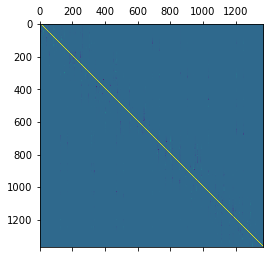

In [15]:
plt.matshow(Q)

In [16]:
cond_A = np.linalg.cond(A_perm.toarray())
cond_Q = np.linalg.cond(Q)
print('cond_A=', cond_A)
print('cond_Q=', cond_Q)

cond_A= 109406298.9931573
cond_Q= 23058103.01630414


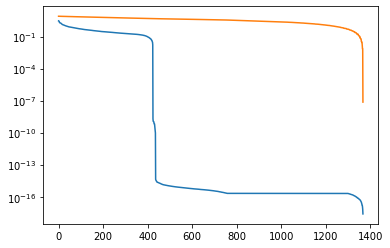

In [17]:
_, ss_Q, _ = np.linalg.svd(Q - np.eye(Q.shape[1]))
# _, ss_Q, _ = np.linalg.svd(Q)
_, ss_A, _ = np.linalg.svd(A_perm.toarray())

plt.semilogy(ss_Q)
plt.semilogy(ss_A)

unpreconditioned:
k=0, res=1.0, err=1.0
k=1, res=0.009471327675036103, err=0.9999727925804518
k=2, res=0.00942448029210236, err=0.9903841193070911
k=3, res=0.009378023946505974, err=0.9901386292682401
k=4, res=0.009332859382261735, err=0.9808676779046325
k=5, res=0.009287976304010378, err=0.9806380299737191
k=6, res=0.009244508591966061, err=0.9717081659153396
k=7, res=0.009201280120915737, err=0.9714882654644894
k=8, res=0.009158646653561147, err=0.962724353280591
k=9, res=0.009116215430725763, err=0.962507478345556
k=10, res=0.009074276651401168, err=0.95388678329289
k=11, res=0.009032533219204227, err=0.9536724072120077
k=12, res=0.008991201266050582, err=0.9451769809091961
k=13, res=0.008950060330875753, err=0.9449649604235646
k=14, res=0.008909268626657743, err=0.9365809470068117
k=15, res=0.00886866475415803, err=0.9363712591268453
k=16, res=0.008828366044486106, err=0.9280887450217673
k=17, res=0.008788252775438005, err=0.9278814493979983
k=18, res=0.008748413918031364, err=0.91

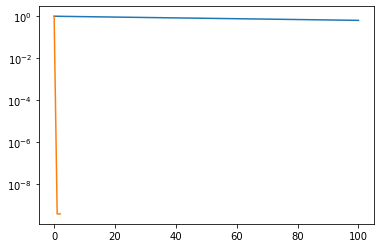

In [18]:
b = np.random.randn(A_perm.shape[1])

x_true = np.linalg.solve(A_perm.toarray(), b)

residuals0=list()
errors0=list()
counter0 = [0,]
def callback(xk):
    k = counter0[0]
    counter0[0] = k+1
    display_str = 'k=' + str(k)

    res = np.linalg.norm(A_perm * xk - b) / np.linalg.norm(b)
    residuals0.append(res)
    display_str += ', res=' + str(res)

    err = np.linalg.norm(x_true - xk) / np.linalg.norm(x_true)
    errors0.append(err)
    display_str += ', err=' + str(err)

    print(display_str)

print('unpreconditioned:')
x0 = spla.gmres(A_perm, b, restart=100, maxiter=100, tol=1e-10, callback=callback, callback_type='x')[0]

residuals1=list()
errors1=list()
counter1 = [0,]
def callback(xk):
    k = counter1[0]
    counter1[0] = k+1
    display_str = 'k=' + str(k)

    res = np.linalg.norm(A_perm * xk - b) / np.linalg.norm(b)
    residuals1.append(res)
    display_str += ', res=' + str(res)

    err = np.linalg.norm(x_true - xk) / np.linalg.norm(x_true)
    errors1.append(err)
    display_str += ', err=' + str(err)

    print(display_str)

print('H-matrix preconditioned:')
x1 = spla.gmres(A_perm, b, M=np.linalg.inv(A2_perm), restart=100, maxiter=100, tol=1e-10, callback=callback, callback_type='x')[0]

plt.semilogy(errors0)
plt.semilogy(errors1)

Expand matrix to make it $2^k \times 2^k$

In [ ]:
leaf_sizes = list()
working_clusters = [ct.root]
while working_clusters:
    C = working_cluster.pop()
    if C.is_leaf:
        leaf_sizes.append(C.stop - C.start)
    else:
        working_clusters = working_clusters + C.children